<h1>Combining Alpha Signals<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Bundle-&amp;-Pipeline-Engine" data-toc-modified-id="Data-Bundle-&amp;-Pipeline-Engine-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Bundle &amp; Pipeline Engine</a></span></li><li><span><a href="#Alpha-Factors" data-toc-modified-id="Alpha-Factors-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Alpha Factors</a></span></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Feature Engineering</a></span><ul class="toc-item"><li><span><a href="#Train/Valid/Test-Splits" data-toc-modified-id="Train/Valid/Test-Splits-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Train/Valid/Test Splits</a></span></li></ul></li><li><span><a href="#Random-Forests" data-toc-modified-id="Random-Forests-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Random Forests</a></span><ul class="toc-item"><li><span><a href="#Initial-RF-Model" data-toc-modified-id="Initial-RF-Model-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Initial RF Model</a></span><ul class="toc-item"><li><span><a href="#Results" data-toc-modified-id="Results-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Results</a></span></li></ul></li></ul></li><li><span><a href="#Overlapping-Samples" data-toc-modified-id="Overlapping-Samples-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Overlapping Samples</a></span><ul class="toc-item"><li><span><a href="#Solution-#1:-Drop-Overlapping-Samples" data-toc-modified-id="Solution-#1:-Drop-Overlapping-Samples-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Solution #1: Drop Overlapping Samples</a></span></li><li><span><a href="#Solution-#2:-Reduce-the-Bag-Size" data-toc-modified-id="Solution-#2:-Reduce-the-Bag-Size-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Solution #2: Reduce the Bag Size</a></span></li><li><span><a href="#Solution-#3:-Ensemble-of-non-overlapping-trees" data-toc-modified-id="Solution-#3:-Ensemble-of-non-overlapping-trees-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Solution #3: Ensemble of non-overlapping trees</a></span></li></ul></li><li><span><a href="#Final-Model" data-toc-modified-id="Final-Model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Final Model</a></span><ul class="toc-item"><li><span><a href="#Re-Training-Model-w/Reduction-in-Bag-Size" data-toc-modified-id="Re-Training-Model-w/Reduction-in-Bag-Size-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Re-Training Model w/Reduction in Bag Size</a></span><ul class="toc-item"><li><span><a href="#Results" data-toc-modified-id="Results-6.1.1"><span class="toc-item-num">6.1.1&nbsp;&nbsp;</span>Results</a></span></li></ul></li><li><span><a href="#Re-Training-Model-w/Ensemble-of-Non-Overlapping-Labels" data-toc-modified-id="Re-Training-Model-w/Ensemble-of-Non-Overlapping-Labels-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Re-Training Model w/Ensemble of Non-Overlapping Labels</a></span><ul class="toc-item"><li><span><a href="#Results" data-toc-modified-id="Results-6.2.1"><span class="toc-item-num">6.2.1&nbsp;&nbsp;</span>Results</a></span></li></ul></li></ul></li></ul></div>

This project builds off the [factor model project](https://github.com/keniba/factor_model) where a simple mean was used to combine the alpha signals, here: 
 - additional features are added such as date, regime, stock volatilitity
 - the signals are combined using a random forest for enhanced alpha
 - demonstrates how to address overlapping labels issue (rolling autocorrelation) with DTs/Random Forests

---

**note**: end of day data from Quotemedia, and sector data from Sharadar was used which could not be shared due to licensing restrictions

In [ ]:
import sys
!{sys.executable} -m pip install -r requirements.txt

In [2]:
import putils
import project_tests

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)

## Data Bundle & Pipeline Engine
---
Using `zipline` to handle the data, and build the pipeline engine

In [3]:
import os
from zipline.data import bundles

os.environ['ZIPLINE_ROOT'] = os.path.join(os.getcwd(), 'assets', 'eod')

ingest_func = bundles.csvdir.csvdir_equities(['daily'], putils.EOD_BUNDLE_NAME)
bundles.register(putils.EOD_BUNDLE_NAME, ingest_func)

print('Data Registered')

Data Registered


In [4]:
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume
from zipline.utils.calendars import get_calendar


universe = AverageDollarVolume(window_length=120).top(500) 
trading_calendar = get_calendar('NYSE') 
bundle_data = bundles.load(putils.EOD_BUNDLE_NAME)
engine = putils.build_pipeline_engine(bundle_data, trading_calendar)

**Universe**

In [5]:
universe_end_date = pd.Timestamp('2016-01-05', tz='UTC')

universe_tickers = engine\
    .run_pipeline(
        Pipeline(screen=universe),
        universe_end_date,
        universe_end_date)\
    .index.get_level_values(1)\
    .values.tolist()
    
universe_tickers

[Equity(0 [A]),
 Equity(1 [AAL]),
 Equity(2 [AAP]),
 Equity(3 [AAPL]),
 Equity(4 [ABBV]),
 Equity(5 [ABC]),
 Equity(6 [ABT]),
 Equity(7 [ACN]),
 Equity(8 [ADBE]),
 Equity(9 [ADI]),
 Equity(10 [ADM]),
 Equity(11 [ADP]),
 Equity(12 [ADS]),
 Equity(13 [ADSK]),
 Equity(14 [AEE]),
 Equity(15 [AEP]),
 Equity(16 [AES]),
 Equity(17 [AET]),
 Equity(18 [AFL]),
 Equity(19 [AGN]),
 Equity(20 [AIG]),
 Equity(21 [AIV]),
 Equity(22 [AIZ]),
 Equity(23 [AJG]),
 Equity(24 [AKAM]),
 Equity(25 [ALB]),
 Equity(26 [ALGN]),
 Equity(27 [ALK]),
 Equity(28 [ALL]),
 Equity(29 [ALLE]),
 Equity(30 [ALXN]),
 Equity(31 [AMAT]),
 Equity(32 [AMD]),
 Equity(33 [AME]),
 Equity(34 [AMG]),
 Equity(35 [AMGN]),
 Equity(36 [AMP]),
 Equity(37 [AMT]),
 Equity(38 [AMZN]),
 Equity(39 [ANDV]),
 Equity(40 [ANSS]),
 Equity(41 [ANTM]),
 Equity(42 [AON]),
 Equity(43 [AOS]),
 Equity(44 [APA]),
 Equity(45 [APC]),
 Equity(46 [APD]),
 Equity(47 [APH]),
 Equity(48 [ARE]),
 Equity(49 [ARNC]),
 Equity(50 [ATVI]),
 Equity(51 [AVB]),
 Equity(

**Returns Data**

In [6]:
from zipline.data.data_portal import DataPortal


data_portal = DataPortal(
    bundle_data.asset_finder,
    trading_calendar=trading_calendar,
    first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_minute_reader=None,
    equity_daily_reader=bundle_data.equity_daily_bar_reader,
    adjustment_reader=bundle_data.adjustment_reader)

`get_pricing` to get the pricing from the data portal

In [7]:
def get_pricing(data_portal, trading_calendar, assets, start_date, end_date, field='close'):
    end_dt = pd.Timestamp(end_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')
    start_dt = pd.Timestamp(start_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')

    end_loc = trading_calendar.closes.index.get_loc(end_dt)
    start_loc = trading_calendar.closes.index.get_loc(start_dt)

    return data_portal.get_history_window(
        assets=assets,
        end_dt=end_dt,
        bar_count=end_loc - start_loc,
        frequency='1d',
        field=field,
        data_frequency='daily')

## Alpha Factors
---
It's time to start working on the alpha factors. In this project, we'll use the following factors:
- Momentum 1 Year Factor
- Mean Reversion 5 Day Sector Neutral Smoothed Factor
- Overnight Sentiment Smoothed Factor - using the hypothesis from the paper [_Overnight Returns and Firm-Specific Investor Sentiment_](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2554010)
 - The finding discussed in detail is that Trailing 5-day Overnight returns exhibit both momentum (persistence) and mean-reversion. Stocks with high weekly overnight returns outperform for up to 4 weeks. Then exhibit mean-reversion.

In [8]:
from zipline.pipeline.factors import CustomFactor, DailyReturns, Returns, SimpleMovingAverage, AnnualizedVolatility
from zipline.pipeline.data import USEquityPricing


factor_start_date = universe_end_date - pd.DateOffset(years=3, days=2)
sector = putils.Sector()

def momentum_1yr(window_length, universe, sector):
    return Returns(window_length=window_length, mask=universe) \
        .demean(groupby=sector) \
        .rank() \
        .zscore()

def mean_reversion_5day_sector_neutral_smoothed(window_length, universe, sector):
    unsmoothed_factor = -Returns(window_length=window_length, mask=universe) \
        .demean(groupby=sector) \
        .rank() \
        .zscore()
    return SimpleMovingAverage(inputs=[unsmoothed_factor], window_length=window_length) \
        .rank() \
        .zscore()

class CTO(Returns):
    """
    Computes the overnight return, per hypothesis from
    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2554010
    """
    inputs = [USEquityPricing.open, USEquityPricing.close]
    
    def compute(self, today, assets, out, opens, closes):
        """
        The opens and closes matrix is 2 rows x N assets, with the most recent at the bottom.
        As such, opens[-1] is the most recent open, and closes[0] is the earlier close
        """
        out[:] = (opens[-1] - closes[0]) / closes[0]
        
class TrailingOvernightReturns(Returns):
    """
    Sum of trailing 1m O/N returns
    """
    window_safe = True
    
    def compute(self, today, asset_ids, out, cto):
        out[:] = np.nansum(cto, axis=0)

def overnight_sentiment_smoothed(cto_window_length, trail_overnight_returns_window_length, universe):
    cto_out = CTO(mask=universe, window_length=cto_window_length)
    unsmoothed_factor = TrailingOvernightReturns(inputs=[cto_out], window_length=trail_overnight_returns_window_length) \
        .rank() \
        .zscore()
    return SimpleMovingAverage(inputs=[unsmoothed_factor], window_length=trail_overnight_returns_window_length) \
        .rank() \
        .zscore()

**Adding the factors to the Pipeline**

In [9]:
universe = AverageDollarVolume(window_length=120).top(500)
sector = putils.Sector()

pipeline = Pipeline(screen=universe)
pipeline.add(
    momentum_1yr(252, universe, sector),
    'Momentum_1YR')
pipeline.add(
    mean_reversion_5day_sector_neutral_smoothed(20, universe, sector),
    'Mean_Reversion_Sector_Neutral_Smoothed')
pipeline.add(
    overnight_sentiment_smoothed(2, 10, universe),
    'Overnight_Sentiment_Smoothed')

## Feature Engineering
---


**"Universal" Quant Features**
- Stock Volatility 20d, 120d
- Stock Dollar Volume 20d, 120d
- Sector

In [10]:
pipeline.add(AnnualizedVolatility(window_length=20, mask=universe).rank().zscore(), 'volatility_20d')
pipeline.add(AnnualizedVolatility(window_length=120, mask=universe).rank().zscore(), 'volatility_120d')
pipeline.add(AverageDollarVolume(window_length=20, mask=universe).rank().zscore(), 'adv_20d')
pipeline.add(AverageDollarVolume(window_length=120, mask=universe).rank().zscore(), 'adv_120d')
pipeline.add(sector, 'sector_code')

**Regime Features**
capture market-wide regimes
- High and low volatility 20d, 120d
- High and low dispersion 20d, 120d

In [11]:
class MarketDispersion(CustomFactor):
    inputs = [DailyReturns()]
    window_length = 1
    window_safe = True

    def compute(self, today, assets, out, returns):
        # returns are days in rows, assets across columns
        out[:] = np.sqrt(np.nanmean((returns - np.nanmean(returns))**2))


pipeline.add(SimpleMovingAverage(inputs=[MarketDispersion(mask=universe)], window_length=20), 'dispersion_20d')
pipeline.add(SimpleMovingAverage(inputs=[MarketDispersion(mask=universe)], window_length=120), 'dispersion_120d')

In [12]:
class MarketVolatility(CustomFactor):
    inputs = [DailyReturns()]
    window_length = 1
    window_safe = True
    
    def compute(self, today, assets, out, returns):
        mkt_returns = np.nanmean(returns, axis=1)
        out[:] = np.sqrt(260.* np.nanmean((mkt_returns-np.nanmean(mkt_returns))**2))


pipeline.add(MarketVolatility(window_length=20), 'market_vol_20d')
pipeline.add(MarketVolatility(window_length=120), 'market_vol_120d')

**Target**
 - target to predict is the *fwd 1w return*

In [13]:
pipeline.add(Returns(window_length=5, mask=universe).quantiles(2), 'return_5d')
pipeline.add(Returns(window_length=5, mask=universe).quantiles(25), 'return_5d_p')

**Date Features**

In [14]:
all_factors = engine.run_pipeline(pipeline, factor_start_date, universe_end_date)

all_factors['is_Janaury'] = all_factors.index.get_level_values(0).month == 1
all_factors['is_December'] = all_factors.index.get_level_values(0).month == 12
all_factors['weekday'] = all_factors.index.get_level_values(0).weekday
all_factors['quarter'] = all_factors.index.get_level_values(0).quarter
all_factors['qtr_yr'] = all_factors.quarter.astype('str') + '_' + all_factors.index.get_level_values(0).year.astype('str')
all_factors['month_end'] = all_factors.index.get_level_values(0).isin(pd.date_range(start=factor_start_date, end=universe_end_date, freq='BM'))
all_factors['month_start'] = all_factors.index.get_level_values(0).isin(pd.date_range(start=factor_start_date, end=universe_end_date, freq='BMS'))
all_factors['qtr_end'] = all_factors.index.get_level_values(0).isin(pd.date_range(start=factor_start_date, end=universe_end_date, freq='BQ'))
all_factors['qtr_start'] = all_factors.index.get_level_values(0).isin(pd.date_range(start=factor_start_date, end=universe_end_date, freq='BQS'))

all_factors.head()

Mean_Reversion_Sector_Neutral_Smoothed  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                                -0.26276899   
                          Equity(1 [AAL])                               0.09992624   
                          Equity(2 [AAP])                               1.66913824   
                          Equity(3 [AAPL])                              1.69874602   
                          Equity(4 [ABBV])                                     nan   

                                            Momentum_1YR  \
2013-01-03 00:00:00+00:00 Equity(0 [A])      -1.20797813   
                          Equity(1 [AAL])     1.71347052   
                          Equity(2 [AAP])    -1.53506144   
                          Equity(3 [AAPL])    1.19311071   
                          Equity(4 [ABBV])           nan   

                                            Overnight_Sentiment_Smoothed  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                      -1.48566901   
                          Equity(1 [AAL])                     0.91934963   
                          Equity(2 [AAP])                     1.50773340   
                          Equity(3 [AAPL])                   -1.36799226   
                          Equity(4 [ABBV])                   -0.25006310   

                                              adv_120d     adv_20d  \
2013-01-03 00:00:00+00:00 Equity(0 [A])     1.33857307  1.39741144   
                          Equity(1 [AAL])   1.13999355  1.08115517   
                          Equity(2 [AAP])  -0.30154668 -0.91934963   
                          Equity(3 [AAPL])  1.72837731  1.72837731   
                          Equity(4 [ABBV]) -1.72837731 -1.64747455   

                                            dispersion_120d  dispersion_20d  \
2013-01-03 00:00:00+00:00 Equity(0 [A])          0.01326964      0.01117804   
                          Equity(1 [AAL])        0.01326964      0.01117804   
                          Equity(2 [AAP])        0.01326964      0.01117804   
                          Equity(3 [AAPL])       0.01326964      0.01117804   
                          Equity(4 [ABBV])       0.01459524      0.01459524   

                                            market_vol_120d  market_vol_20d  \
2013-01-03 00:00:00+00:00 Equity(0 [A])          0.12966421      0.13758558   
                          Equity(1 [AAL])        0.12966421      0.13758558   
                          Equity(2 [AAP])        0.12966421      0.13758558   
                          Equity(3 [AAPL])       0.12966421      0.13758558   
                          Equity(4 [ABBV])       0.12966421      0.13758558   

                                            return_5d    ...     \
2013-01-03 00:00:00+00:00 Equity(0 [A])             0    ...      
                          Equity(1 [AAL])           1    ...      
                          Equity(2 [AAP])           0    ...      
                          Equity(3 [AAPL])          1    ...      
                          Equity(4 [ABBV])         -1    ...      

                                            volatility_20d  is_Janaury  \
2013-01-03 00:00:00+00:00 Equity(0 [A])        -1.21980876        True   
                          Equity(1 [AAL])       1.56621970        True   
                          Equity(2 [AAP])      -1.47040391        True   
                          Equity(3 [AAPL])      1.61781282        True   
                          Equity(4 [ABBV])             nan        True   

                                            is_December  weekday quarter  \
2013-01-03 00:00:00+00:00 Equity(0 [A])           False        3       1   
                          Equity(1 [AAL])         False        3       1   
                          Equity(2 [AAP])         False        3       1   
                          Equity(3 [AAPL])        False        3       1   
                          Equity(4 [ABBV])        False        3       1   

                                 

**Sectors**

In [17]:
sector_lookup = pd.read_csv(
    os.path.join(os.getcwd(), '..', '..', 'data', 'project_7_sector', 'labels.csv'),
    index_col='Sector_i')['Sector'].to_dict()
sector_lookup

sector_columns = []
for sector_i, sector_name in sector_lookup.items():
    secotr_column = 'sector_{}'.format(sector_name)
    sector_columns.append(secotr_column)
    all_factors[secotr_column] = (all_factors['sector_code'] == sector_i)

all_factors[sector_columns].head()

sector_Healthcare  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                 True   
                          Equity(1 [AAL])              False   
                          Equity(2 [AAP])              False   
                          Equity(3 [AAPL])             False   
                          Equity(4 [ABBV])              True   

                                           sector_Technology  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                False   
                          Equity(1 [AAL])              False   
                          Equity(2 [AAP])              False   
                          Equity(3 [AAPL])              True   
                          Equity(4 [ABBV])             False   

                                           sector_Consumer Defensive  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                        False   
                          Equity(1 [AAL])                      False   
                          Equity(2 [AAP])                      False   
                          Equity(3 [AAPL])                     False   
                          Equity(4 [ABBV])                     False   

                                           sector_Industrials  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                 False   
                          Equity(1 [AAL])                True   
                          Equity(2 [AAP])               False   
                          Equity(3 [AAPL])              False   
                          Equity(4 [ABBV])              False   

                                           sector_Utilities  \
2013-01-03 00:00:00+00:00 Equity(0 [A])               False   
                          Equity(1 [AAL])             False   
                          Equity(2 [AAP])             False   
                          Equity(3 [AAPL])            False   
                          Equity(4 [ABBV])            False   

                                           sector_Financial Services  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                        False   
                          Equity(1 [AAL])                      False   
                          Equity(2 [AAP])                      False   
                          Equity(3 [AAPL])                     False   
                          Equity(4 [ABBV])                     False   

                                           sector_Real Estate  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                 False   
                          Equity(1 [AAL])               False   
                          Equity(2 [AAP])               False   
                          Equity(3 [AAPL])              False   
                          Equity(4 [ABBV])              False   

                                           sector_Communication Services  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                            False   
                          Equity(1 [AAL])                          False   
                          Equity(2 [AAP])                          False   
                          Equity(3 [AAPL])                         False   
                          Equity(4 [ABBV])                         False   

                                           sector_Consumer Cyclical  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                       False   
                          Equity(1 [AAL])                     False   
                          Equity(2 [AAP])                      True   
                          Equity(3 [AAPL])                    False   
                          Equity(4 [ABBV])                    False   

                                           sector_Energy  \
2013-01-03 00:00:00+00:00 Equity(0 [A])            False   
                          Equity(1 [AAL])          False   
                          Equity(2 [AAP])          False   
                          Equity(3 [AAPL])         False   
                          Equity(4 [ABBV])         False   

 

**Shift Target**
 - shift fwd returns back to act as target

In [18]:
all_factors['target'] = all_factors.groupby(level=1)['return_5d'].shift(-5)

all_factors[['return_5d','target']].reset_index().sort_values(['level_1', 'level_0']).head(10)

,level_0,level_1,return_5d,target
0,2013-01-03 00:00:00+00:00,Equity(0 [A]),0,0.00000000
471,2013-01-04 00:00:00+00:00,Equity(0 [A]),0,0.00000000
942,2013-01-07 00:00:00+00:00,Equity(0 [A]),0,0.00000000
1413,2013-01-08 00:00:00+00:00,Equity(0 [A]),0,1.00000000
1884,2013-01-09 00:00:00+00:00,Equity(0 [A]),0,0.00000000
2355,2013-01-10 00:00:00+00:00,Equity(0 [A]),0,0.00000000
2826,2013-01-11 00:00:00+00:00,Equity(0 [A]),0,0.00000000
3297,2013-01-14 00:00:00+00:00,Equity(0 [A]),0,0.00000000
3768,2013-01-15 00:00:00+00:00,Equity(0 [A]),1,0.00000000
4239,2013-01-16 00:00:00+00:00,Equity(0 [A]),0,0.00000000


**Target IID Check**
 - whether returns are independent and identically distributed
 - results indicate rolling autocorrelations move together, with the highest being 1-day shifted and lowest being 4-day shifted

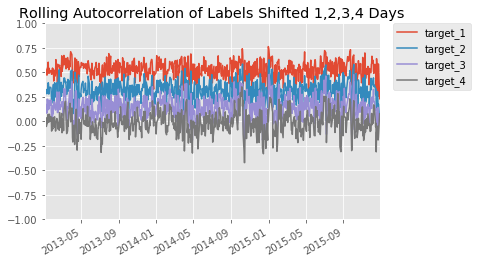

In [19]:
from scipy.stats import spearmanr


def sp(group, col1_name, col2_name):
    x = group[col1_name]
    y = group[col2_name]
    return spearmanr(x, y)[0]


all_factors['target_p'] = all_factors.groupby(level=1)['return_5d_p'].shift(-5)
all_factors['target_1'] = all_factors.groupby(level=1)['return_5d'].shift(-4)
all_factors['target_2'] = all_factors.groupby(level=1)['return_5d'].shift(-3)
all_factors['target_3'] = all_factors.groupby(level=1)['return_5d'].shift(-2)
all_factors['target_4'] = all_factors.groupby(level=1)['return_5d'].shift(-1)

g = all_factors.dropna().groupby(level=0)
for i in range(4):
    label = 'target_'+str(i+1)
    ic = g.apply(sp, 'target', label)
    ic.plot(ylim=(-1, 1), label=label)
plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.title('Rolling Autocorrelation of Labels Shifted 1,2,3,4 Days')
plt.show()

### Train/Valid/Test Splits
 - a single day is will not be split across multiple datasets

In [21]:
def train_valid_test_split(all_x, all_y, train_size, valid_size, test_size):
    """
    Generates the train, validation, and test dataset.

    Parameters
    ----------
    all_x : DataFrame
        All the input samples
    all_y : Pandas Series
        All the target values
    train_size : float
        The proportion of the data used for the training dataset
    valid_size : float
        The proportion of the data used for the validation dataset
    test_size : float
        The proportion of the data used for the test dataset

    Returns
    -------
    x_train : DataFrame
        The train input samples
    x_valid : DataFrame
        The validation input samples
    x_test : DataFrame
        The test input samples
    y_train : Pandas Series
        The train target values
    y_valid : Pandas Series
        The validation target values
    y_test : Pandas Series
        The test target values
    """
    assert train_size >= 0 and train_size <= 1.0
    assert valid_size >= 0 and valid_size <= 1.0
    assert test_size >= 0 and test_size <= 1.0
    assert train_size + valid_size + test_size == 1.0
    
    train_end = int(all_x.shape[0]*(1- test_size - valid_size))
    valid_end = train_end + int(all_x.shape[0]*valid_size)
    
    x_train, y_train = all_x.iloc[:train_end,], all_y.iloc[:train_end,]
    x_valid, y_valid = all_x.iloc[(train_end):valid_end,], all_y.iloc[(train_end):valid_end,]
    x_test, y_test = all_x.iloc[(valid_end):,], all_y.iloc[(valid_end):,]
    
    return x_train, x_valid, x_test, y_train, y_valid, y_test

In [23]:
features = [
    'Mean_Reversion_Sector_Neutral_Smoothed', 'Momentum_1YR',
    'Overnight_Sentiment_Smoothed', 'adv_120d', 'adv_20d',
    'dispersion_120d', 'dispersion_20d', 'market_vol_120d',
    'market_vol_20d', 'volatility_20d',
    'is_Janaury', 'is_December', 'weekday',
    'month_end', 'month_start', 'qtr_end', 'qtr_start'] + sector_columns
target_label = 'target'

temp = all_factors.dropna().copy()
X = temp[features]
y = temp[target_label]

X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(X, y, 0.6, 0.2, 0.2)

X_train.head()

Mean_Reversion_Sector_Neutral_Smoothed  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                                -0.26276899   
                          Equity(1 [AAL])                               0.09992624   
                          Equity(2 [AAP])                               1.66913824   
                          Equity(3 [AAPL])                              1.69874602   
                          Equity(5 [ABC])                              -1.11399249   

                                            Momentum_1YR  \
2013-01-03 00:00:00+00:00 Equity(0 [A])      -1.20797813   
                          Equity(1 [AAL])     1.71347052   
                          Equity(2 [AAP])    -1.53506144   
                          Equity(3 [AAPL])    1.19311071   
                          Equity(5 [ABC])    -0.50920924   

                                            Overnight_Sentiment_Smoothed  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                      -1.48566901   
                          Equity(1 [AAL])                     0.91934963   
                          Equity(2 [AAP])                     1.50773340   
                          Equity(3 [AAPL])                   -1.36799226   
                          Equity(5 [ABC])                    -0.02941919   

                                              adv_120d     adv_20d  \
2013-01-03 00:00:00+00:00 Equity(0 [A])     1.33857307  1.39741144   
                          Equity(1 [AAL])   1.13999355  1.08115517   
                          Equity(2 [AAP])  -0.30154668 -0.91934963   
                          Equity(3 [AAPL])  1.72837731  1.72837731   
                          Equity(5 [ABC])   0.17651513  0.22799871   

                                            dispersion_120d  dispersion_20d  \
2013-01-03 00:00:00+00:00 Equity(0 [A])          0.01326964      0.01117804   
                          Equity(1 [AAL])        0.01326964      0.01117804   
                          Equity(2 [AAP])        0.01326964      0.01117804   
                          Equity(3 [AAPL])       0.01326964      0.01117804   
                          Equity(5 [ABC])        0.01326964      0.01117804   

                                            market_vol_120d  market_vol_20d  \
2013-01-03 00:00:00+00:00 Equity(0 [A])          0.12966421      0.13758558   
                          Equity(1 [AAL])        0.12966421      0.13758558   
                          Equity(2 [AAP])        0.12966421      0.13758558   
                          Equity(3 [AAPL])       0.12966421      0.13758558   
                          Equity(5 [ABC])        0.12966421      0.13758558   

                                            volatility_20d  \
2013-01-03 00:00:00+00:00 Equity(0 [A])        -1.21980876   
                          Equity(1 [AAL])       1.56621970   
                          Equity(2 [AAP])      -1.47040391   
                          Equity(3 [AAPL])      1.61781282   
                          Equity(5 [ABC])      -1.36721767   

                                                    ...            \
2013-01-03 00:00:00+00:00 Equity(0 [A])             ...             
                          Equity(1 [AAL])           ...             
                          Equity(2 [AAP])           ...             
                          Equity(3 [AAPL])          ...             
                          Equity(5 [ABC])           ...             

                                           sector_Technology  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                False   
                          Equity(1 [AAL])              False   
                          Equity(2 [AAP])              False   
                          Equity(3 [AAPL])              True   
                          Equity(5 [ABC])              False   

                                           sector_Consumer Defensive  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                        False   
                     

## Random Forests

In [ ]:
from IPython.display import display
from sklearn.tree import DecisionTreeClassifier

**Random Forests Parameters**
 - different tree sizes
 - `min_samples_leaf`: control to allow tree to fit the data with enough detail, but not overfit

In [25]:
n_days = 10
n_stocks = 500

clf_parameters = {
    'criterion': 'entropy',
    'min_samples_leaf': n_stocks * n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': clf_random_state}
n_trees_l = [50, 100, 250, 500, 1000]

### Initial RF Model

In [26]:
from sklearn.ensemble import RandomForestClassifier

train_score = []
valid_score = []
oob_score = []
feature_importances = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    clf.fit(X_train, y_train)
    
    train_score.append(clf.score(X_train, y_train.values))
    valid_score.append(clf.score(X_valid, y_valid.values))
    oob_score.append(clf.oob_score_)
    feature_importances.append(clf.feature_importances_)

Training Models: 100%|██████████| 5/5 [08:46<00:00, 105.40s/Model]


 - In the case of training/oob data, accuracy does not improve much after aprox. 250 trees. As for validation, accuracy stops declining after the same threshold, and peaks at aprox. 500 trees
 - oob is underestimating validation accuracy, meaning the model could be slighly overfitting, the trees are correlated

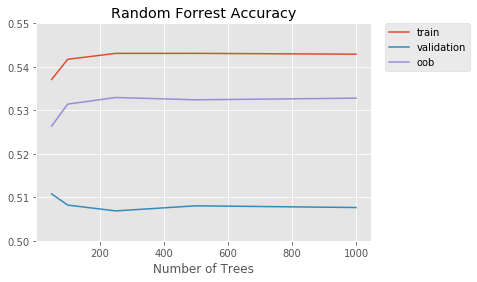

In [27]:
putils.plot(
    [n_trees_l]*3,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

In [28]:
print('Features Ranked by Average Importance:\n')
putils.rank_features_by_importance(np.average(feature_importances, axis=0), features)

Features Ranked by Average Importance:

      Feature                                    Importance
 1. dispersion_20d                         (0.12728185487944446)
 2. volatility_20d                         (0.1224273557087611)
 3. market_vol_120d                        (0.10513743366026762)
 4. market_vol_20d                         (0.10381897786540781)
 5. Momentum_1YR                           (0.0945797742561591)
 6. dispersion_120d                        (0.08005632079067652)
 7. Overnight_Sentiment_Smoothed           (0.0774409774770833)
 8. Mean_Reversion_Sector_Neutral_Smoothed (0.06912219864639728)
 9. adv_120d                               (0.0599502823871783)
10. adv_20d                                (0.054561747673325986)
11. sector_Healthcare                      (0.031652039665357366)
12. sector_Basic Materials                 (0.012388131735165828)
13. sector_Consumer Defensive              (0.011213976999730849)
14. sector_Industrials                     (0.010670656

#### Results
`show_sample_results` shows the following results of a model:
- Sharpe Ratios
- Factor Returns
- Factor Rank Autocorrelation

In [29]:
import alphalens as al

all_assets = all_factors.index.levels[1].values.tolist()
all_pricing = get_pricing(
    data_portal,
    trading_calendar,
    all_assets,
    factor_start_date,
    universe_end_date)

def show_sample_results(data, samples, classifier, factors, pricing=all_pricing):
    # Calculate the Alpha Score
    prob_array=[-1,1]
    alpha_score = classifier.predict_proba(samples).dot(np.array(prob_array))
    
    # Add Alpha Score to rest of the factors
    alpha_score_label = 'AI_ALPHA'
    factors_with_alpha = data.loc[samples.index].copy()
    factors_with_alpha[alpha_score_label] = alpha_score
    
    # Setup data for AlphaLens
    print('Cleaning Data...\n')
    factor_data = putils.build_factor_data(factors_with_alpha[factors + [alpha_score_label]], pricing)
    print('\n-----------------------\n')
    
    # Calculate Factor Returns and Sharpe Ratio
    factor_returns = putils.get_factor_returns(factor_data)
    sharpe_ratio = putils.sharpe_ratio(factor_returns)
    
    # Show Results
    print('             Sharpe Ratios')
    print(sharpe_ratio.round(2))
    putils.plot_factor_returns(factor_returns)
    putils.plot_factor_rank_autocorrelation(factor_data)

**Comparing combined factor `AI_ALPHA` to individual factors**

---

**Training Prediction**

In [30]:
factor_names = [
    'Mean_Reversion_Sector_Neutral_Smoothed',
    'Momentum_1YR',
    'Overnight_Sentiment_Smoothed',
    'adv_120d',
    'volatility_20d']

Cleaning Data...

Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

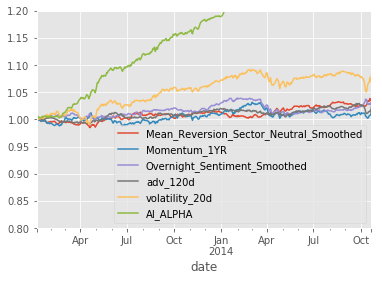

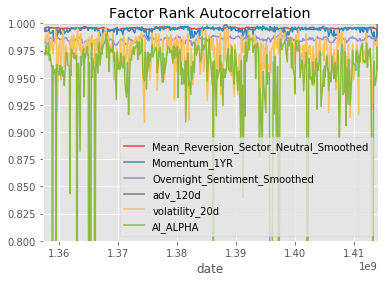

In [31]:
show_sample_results(all_factors, X_train, clf, factor_names)

**Validation Prediction**

 - even when the input factor returns flat to negative the AI Alpha is positive with Sharpe Ratio > 2. 
 - ***need to correct for the non-IID labels and mitigate the overfitting***

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

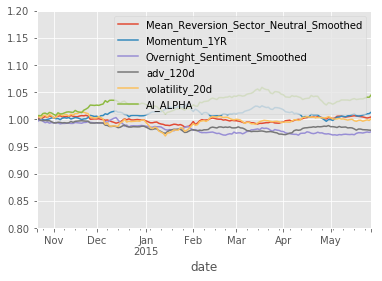

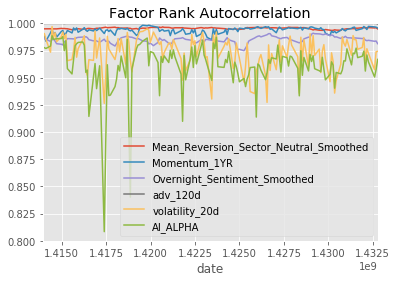

In [28]:
show_sample_results(all_factors, X_valid, clf, factor_names)

## Overlapping Samples
To fix the non-IID sample issue, will demonstrate three approaches

- Don't use overlapping samples
- Use BaggingClassifier's `max_samples`
- Build an ensemble of non-overlapping trees

### Solution #1: Drop Overlapping Samples
This is the simplest of the three methods
- drop any overlapping samples from the dataset
- can cause problems if results in too few datapoints, can occur with rolling 20-day or 252-day returns

In [33]:
def non_overlapping_samples(x, y, n_skip_samples, start_i=0):
    """
    Returns the non overlapping samples.

    Parameters
    ----------
    x : DataFrame
        The input samples
    y : Pandas Series
        The target values
    n_skip_samples : int
        The number of samples to skip
    start_i : int
        The starting index to use for the data
    
    Returns
    -------
    non_overlapping_x : 2 dimensional Ndarray
        The non overlapping input samples
    non_overlapping_y : 1 dimensional Ndarray
        The non overlapping target values
    """
    assert len(x.shape) == 2
    assert len(y.shape) == 1
    
    non_overlapping_x = x.unstack(-1)[start_i::n_skip_samples+1].stack()
    non_overlapping_y = y.unstack(-1)[start_i::n_skip_samples+1].stack()
    
    return non_overlapping_x, non_overlapping_y

**Training the model**

In [34]:
train_score = []
valid_score = []
oob_score = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    clf.fit(*non_overlapping_samples(X_train, y_train, 4))
    
    train_score.append(clf.score(X_train, y_train.values))
    valid_score.append(clf.score(X_valid, y_valid.values))
    oob_score.append(clf.oob_score_)

Training Models: 100%|██████████| 5/5 [01:08<00:00, 13.77s/Model]


**Results**
 - addresses overfitting problem, but the model is significantly less performant

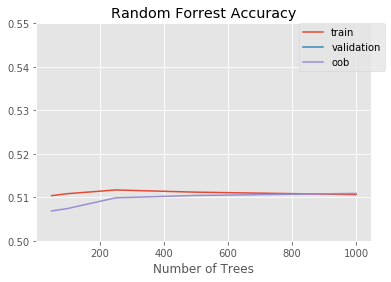

In [35]:
putils.plot(
    [n_trees_l]*3,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

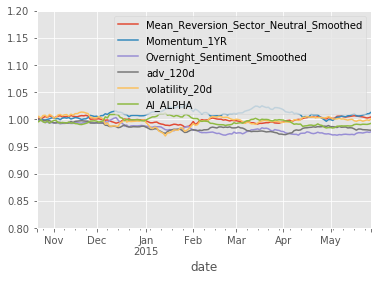

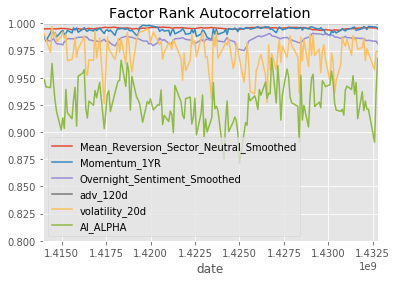

In [36]:
show_sample_results(all_factors, X_valid, clf, factor_names)

### Solution #2: Reduce the Bag Size
 - adjust bagging procedure inside random forest model using BaggingClassifier's `max_samples`- idea is to pick a smaller number of samples for each bag - reducing influence of redundant information
 - reducing bag size by number of features that overlap at each time point - since using weekly returns - reduce to `0.2`
 - This method is proposed by Marcos Lopez de Prado in [Advances in Financial Machine Learning](http://www.quantresearch.org/)

In [38]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier


def bagging_classifier(n_estimators, max_samples, max_features, parameters):
    """
    Builds the bagging classifier.

    Parameters
    ----------
    n_estimators : int 
        The number of base estimators in the ensemble
    max_samples : float 
        The proportion of input samples drawn from when training each base estimator
    max_features : float 
        The proportion of input sample features drawn from when training each base estimator
    parameters : dict
        Parameters to use in building the bagging classifier
        It should contain the following parameters:
            criterion
            min_samples_leaf
            oob_score
            n_jobs
            random_state
    
    Returns
    -------
    bagging_clf : Scikit-Learn BaggingClassifier
        The bagging classifier
    """
    
    required_parameters = {'criterion', 'min_samples_leaf', 'oob_score', 'n_jobs', 'random_state'}
    assert not required_parameters - set(parameters.keys())
    
    base_clf = DecisionTreeClassifier(
        criterion=parameters['criterion'], 
        max_features=max_features, 
        min_samples_leaf=parameters['min_samples_leaf']
    )
    
    bagging_clf = BaggingClassifier(
        base_estimator=base_clf,
        n_estimators=n_estimators, 
        max_samples=max_samples,
        bootstrap=True,
        oob_score=parameters['oob_score'],
        n_jobs=parameters['n_jobs'],
        verbose=0,
        random_state=parameters['random_state']
    )
    
    return bagging_clf

**Train Model**

In [39]:
train_score = []
valid_score = []
oob_score = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = bagging_classifier(n_trees, 0.2, 1.0, clf_parameters)
    clf.fit(X_train, y_train)
    
    train_score.append(clf.score(X_train, y_train.values))
    valid_score.append(clf.score(X_valid, y_valid.values))
    oob_score.append(clf.oob_score_)

Training Models: 100%|██████████| 5/5 [12:47<00:00, 153.48s/Model]


**Results**

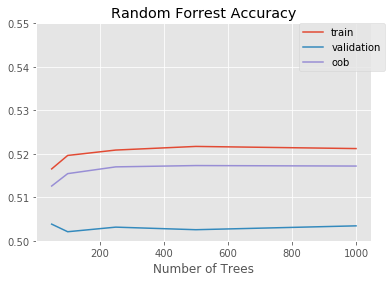

In [40]:
putils.plot(
    [n_trees_l]*3,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

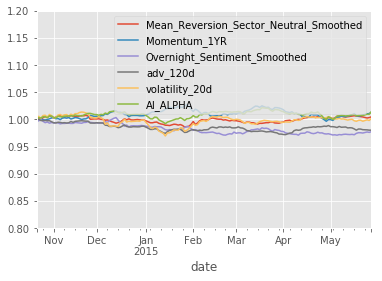

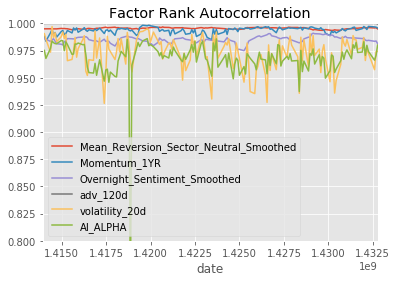

In [41]:
show_sample_results(all_factors, X_valid, clf, factor_names)

### Solution #3: Ensemble of non-overlapping trees
 - break down into non-overlapping models
 - in a weekly setting, build 5 models using non-overlapping days, then ensemble the models

In [49]:
import abc

from sklearn.ensemble import VotingClassifier
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import Bunch


class NoOverlapVoter(VotingClassifier):
    
    def __init__(self, estimator, voting='soft', n_skip_samples=4):
        # List of estimators for all the subsets of data
        estimators = [('clf'+str(i), estimator) for i in range(n_skip_samples + 1)]
        
        self.n_skip_samples = n_skip_samples
        super().__init__(estimators, voting)
        
    # Average of all the estimators' oob scores
    def calculate_oob_score(classifiers):
        """
        Calculates the mean out-of-bag score from the classifiers.

        Parameters
        ----------
        classifiers : list of Scikit-Learn Classifiers
            The classifiers used to calculate the mean out-of-bag score

        Returns
        -------
        oob_score : float
            The mean out-of-bag score
        """

        oob = 0
        for clf in classifiers:
            oob = oob + clf.oob_score_

        oob_score = oob/len(classifiers)

        return oob_score
    
    # builds non overlapping subsets of the data, then run a estimator on each subset of data
    def non_overlapping_estimators(x, y, classifiers, n_skip_samples):
        """
        Fits the classifiers to non overlapping data.

        Parameters
        ----------
        x : DataFrame
            The input samples
        y : Pandas Series
            The target values
        classifiers : list of Scikit-Learn Classifiers
            The classifiers used to fit on the non overlapping data
        n_skip_samples : int
            The number of samples to skip

        Returns
        -------
        fit_classifiers : list of Scikit-Learn Classifiers
            The classifiers fit to the the non overlapping data
        """

        fit_classifiers = []

        for i in range(n_skip_samples):
            clf = classifiers[i].fit(x[i::n_skip_samples], y[i::n_skip_samples])
            fit_classifiers.append(clf)


        return fit_classifiers
    
    def fit(self, X, y, sample_weight=None):
        estimator_names, clfs = zip(*self.estimators)
        self.le_ = LabelEncoder().fit(y)
        self.classes_ = self.le_.classes_
        
        clone_clfs = [clone(clf) for clf in clfs]
        self.estimators_ = self._non_overlapping_estimators(X, y, clone_clfs, self.n_skip_samples)
        self.named_estimators_ = Bunch(**dict(zip(estimator_names, self.estimators_)))
        self.oob_score_ = self._calculate_oob_score(self.estimators_)
        
        return self
    
    def _calculate_oob_score(self, classifiers):
        return calculate_oob_score(classifiers)
        
    def _non_overlapping_estimators(self, x, y, classifiers, n_skip_samples):
        return non_overlapping_estimators(x, y, classifiers, n_skip_samples)

**Train Model**

In [50]:
train_score = []
valid_score = []
oob_score = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    
    clf_nov = NoOverlapVoter(clf)
    clf_nov.fit(X_train, y_train)
    
    train_score.append(clf_nov.score(X_train, y_train.values))
    valid_score.append(clf_nov.score(X_valid, y_valid.values))
    oob_score.append(clf_nov.oob_score_)

Training Models: 100%|██████████| 5/5 [05:23<00:00, 64.61s/Model]


**Results**

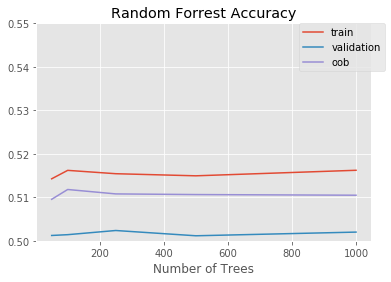

In [51]:
putils.plot(
    [n_trees_l]*3,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

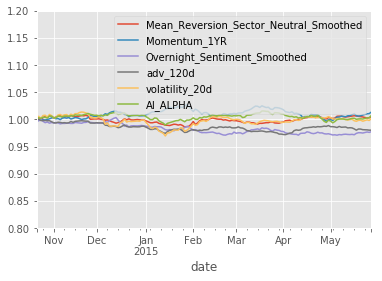

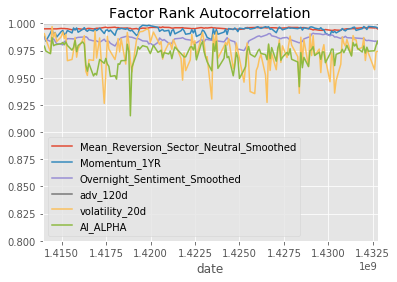

In [52]:
show_sample_results(all_factors, X_valid, clf_nov, factor_names)

## Final Model
---

train on the train & validation dataset

### Re-Training Model w/Reduction in Bag Size

In [53]:
n_trees = 500

clf = bagging_classifier(n_trees, 0.2, 0.1, clf_parameters)
clf.fit(
    pd.concat([X_train, X_valid]),
    pd.concat([y_train, y_valid]))

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=0.1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5000, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.2, n_estimators=500, n_jobs=-1, oob_score=True,
         random_state=0, verbose=0, warm_start=False)

#### Results
---

**Accuracy**

In [54]:
print('train: {}, oob: {}, valid: {}'.format(
    clf.score(X_train, y_train.values),
    clf.score(X_valid, y_valid.values),
    clf.oob_score_))

train: 0.514140531807978, oob: 0.5205133985178506, valid: 0.510725154273155


**Train**

Cleaning Data...

Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

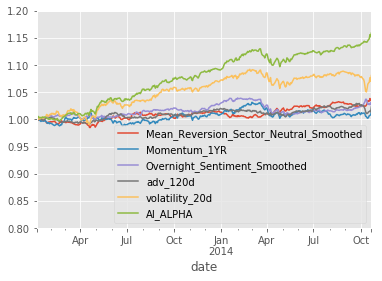

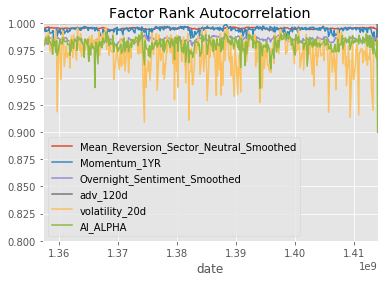

In [55]:
show_sample_results(all_factors, X_train, clf, factor_names)

**Validate**

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

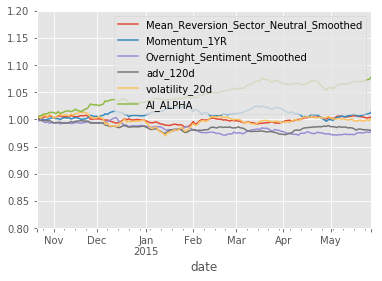

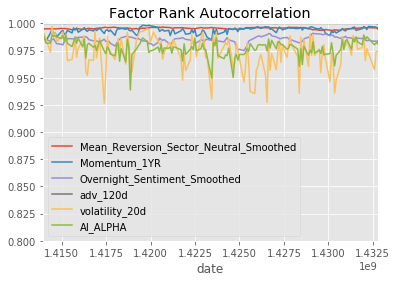

In [56]:
show_sample_results(all_factors, X_valid, clf, factor_names)

**Test**

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

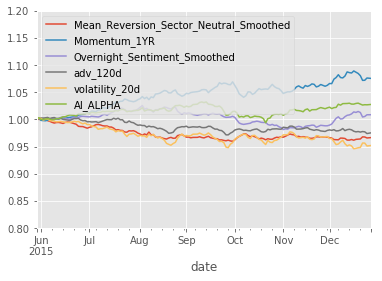

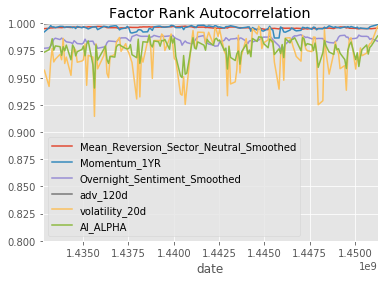

In [57]:
show_sample_results(all_factors, X_test, clf, factor_names)

### Re-Training Model w/Ensemble of Non-Overlapping Labels
---

In [58]:
n_trees = 500

clf = RandomForestClassifier(n_trees, **clf_parameters)
clf_nov = NoOverlapVoter(clf)
clf_nov.fit(
    pd.concat([X_train, X_valid]),
    pd.concat([y_train, y_valid]))

NoOverlapVoter(estimator=None, n_skip_samples=4, voting='soft')

#### Results
---

In [59]:
print('train: {}, oob: {}, valid: {}'.format(
    clf_nov.score(X_train, y_train.values),
    clf_nov.score(X_valid, y_valid.values),
    clf_nov.oob_score_))

train: 0.5172072097457429, oob: 0.5224717518104202, valid: 0.5125214855307278


**Train**

Cleaning Data...

Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

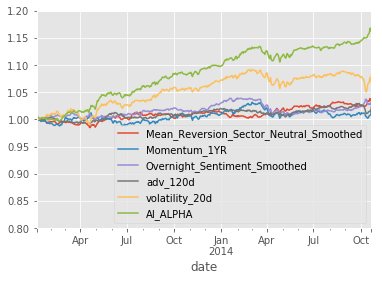

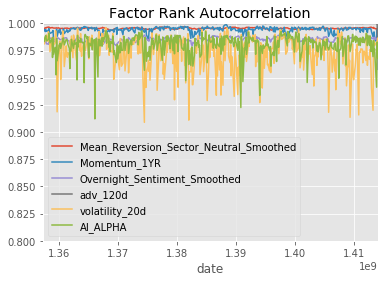

In [60]:
show_sample_results(all_factors, X_train, clf_nov, factor_names)

**Validate**

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

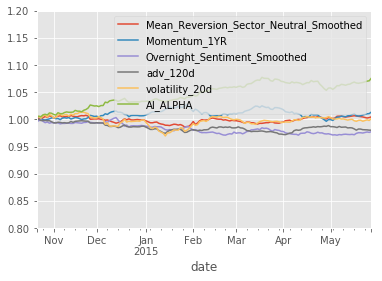

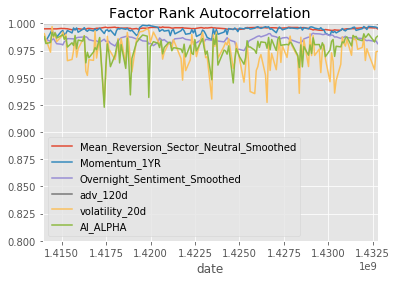

In [61]:
show_sample_results(all_factors, X_valid, clf_nov, factor_names)

**Test**

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

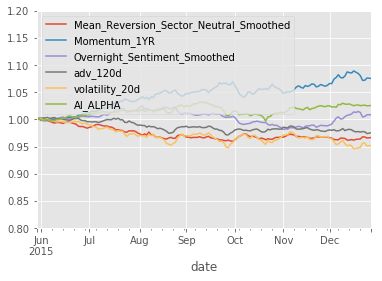

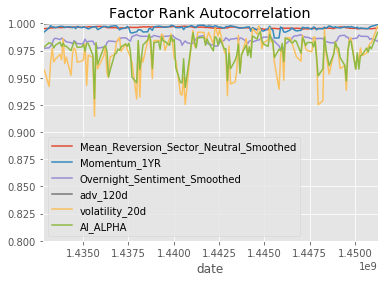

In [62]:
show_sample_results(all_factors, X_test, clf_nov, factor_names)